# Solving the Quadratic Programming problem using CVXOPT with Non-linearly separable data

## Why kernels?

Kernel is an user-specified transformation function that can be applied to features in case they are non-linearly separable. The transformation maps features in higher dimensional space implicitly from the Input space to Feature space. Kernel usually relies on inner-product(dot product) between features. 

<img src="images/svm.png" alt="Kernels with svm" src="https://pythonprogramming.net/kernels-with-svm-machine-learning-tutorial/">

source: [Kernels with SVM](https://pythonprogramming.net/kernels-with-svm-machine-learning-tutorial/)


## Common kernel functions 

<img src="images/kernels.png" alt="Kernels with svm" src="https://pythonprogramming.net/kernels-with-svm-machine-learning-tutorial/">

source: [Support Vector Machine: Kernel Trick; Mercer’s Theorem](https://towardsdatascience.com/understanding-support-vector-machine-part-2-kernel-trick-mercers-theorem-e1e6848c6c4d)

In [49]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as pl
from matplotlib import style
style.use('ggplot')
pl.rcParams['figure.figsize'] = (14, 12)
import cvxopt
import cvxopt.solvers

## Define Kernels 

In [13]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

## Define SVM class

In [14]:
class SVM(object):
    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)
            
    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers (alpha)
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

## Generate Linearly separable dataset 

In [17]:
def gen_lin_separable_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

## Generate Non-linearly separable dataset 

In [18]:
def gen_non_lin_separable_data():
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0,0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, 50)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 50)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

## Generate Linearly separable but overlapping dataset

In [19]:
def gen_lin_separable_overlap_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[1.5, 1.0], [1.0, 1.5]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

## Split Training set 

In [21]:
def split_train(X1, y1, X2, y2):
    X1_train = X1[:90]
    y1_train = y1[:90]
    X2_train = X2[:90]
    y2_train = y2[:90]
    X_train = np.vstack((X1_train, X2_train))
    y_train = np.hstack((y1_train, y2_train))
    return X_train, y_train

## Split Testing set 

In [22]:
def split_test(X1, y1, X2, y2):
    X1_test = X1[90:]
    y1_test = y1[90:]
    X2_test = X2[90:]
    y2_test = y2[90:]
    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))
    return X_test, y_test

## Plotting margins

In [23]:
def plot_margin(X1_train, X2_train, clf):
    # given x, return y such that [x,y] in on the line
    # w.x + b = c
    def f(x, w, b, c=0):
        return (-w[0] * x - b + c) / w[1]

    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

    # w.x + b = 0
    a0 = -4; a1 = f(a0, clf.w, clf.b)
    b0 = 4; b1 = f(b0, clf.w, clf.b)
    pl.plot([a0,b0], [a1,b1], "k")

    # w.x + b = 1
    a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
    b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
    pl.plot([a0,b0], [a1,b1], "k--")

    # w.x + b = -1
    a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
    b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
    pl.plot([a0,b0], [a1,b1], "k--")

    pl.axis("tight")
    pl.show()

def plot_contour(X1_train, X2_train, clf):
    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

    X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = clf.project(X).reshape(X1.shape)
    pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

    pl.axis("tight")
    pl.show()

## Define Linear function 

In [24]:
def test_linear():
    X1, y1, X2, y2 = gen_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM()
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)

## Define Non-linear function 

In [26]:
def test_non_linear():
    X1, y1, X2, y2 = gen_non_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM(polynomial_kernel)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

## Define Non-linear with Soft Margin function 

In [27]:
def test_soft():
    X1, y1, X2, y2 = gen_lin_separable_overlap_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM(C=1000.1)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

## Testing part 

     pcost       dcost       gap    pres   dres
 0: -1.4948e+01 -2.5620e+01  5e+02  2e+01  2e+00
 1: -1.0107e+01 -3.7245e+00  5e+01  2e+00  2e-01
 2: -8.1036e-01 -1.9593e+00  1e+00  4e-15  4e-15
 3: -1.3745e+00 -1.6155e+00  2e-01  1e-15  1e-15
 4: -1.5398e+00 -1.6034e+00  6e-02  3e-16  1e-15
 5: -1.5952e+00 -1.6011e+00  6e-03  9e-16  1e-15
 6: -1.6008e+00 -1.6008e+00  6e-05  5e-16  1e-15
 7: -1.6008e+00 -1.6008e+00  6e-07  2e-15  1e-15
Optimal solution found.
3 support vectors out of 180 points
20 out of 20 predictions correct


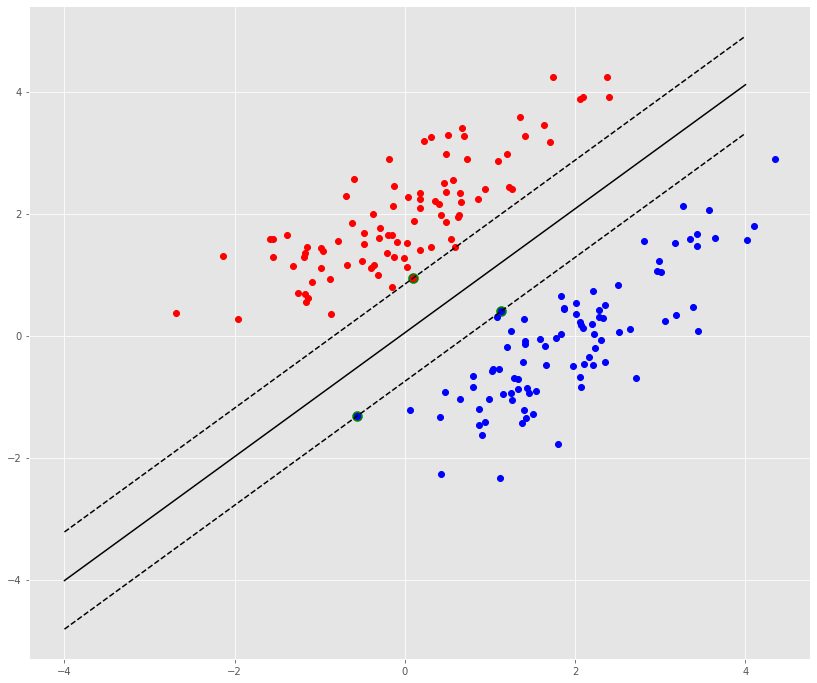

     pcost       dcost       gap    pres   dres
 0: -3.2175e+01 -7.6464e+01  1e+03  3e+01  2e+00
 1: -5.0536e+01 -6.6624e+01  6e+02  2e+01  1e+00
 2: -1.1672e+01 -4.6222e+00  2e+02  5e+00  3e-01
 3: -1.3454e+01 -3.5034e+00  1e+02  3e+00  2e-01
 4: -2.6682e-01 -8.5130e-01  7e+00  1e-01  9e-03
 5:  3.3047e-02 -5.9087e-01  2e+00  3e-02  2e-03
 6: -3.8945e-02 -3.0684e-01  6e-01  6e-03  5e-04
 7: -8.2826e-02 -2.1229e-01  2e-01  3e-03  2e-04
 8: -1.2792e-01 -2.2022e-01  1e-01  1e-03  7e-05
 9: -1.7342e-01 -1.9440e-01  3e-02  2e-04  1e-05
10: -1.7810e-01 -1.9191e-01  2e-02  9e-05  6e-06
11: -1.8369e-01 -1.8924e-01  7e-03  2e-05  2e-06
12: -1.8731e-01 -1.8805e-01  9e-04  3e-06  2e-07
13: -1.8749e-01 -1.8801e-01  6e-04  1e-06  8e-08
14: -1.8792e-01 -1.8794e-01  3e-05  5e-08  3e-09
15: -1.8794e-01 -1.8794e-01  3e-07  5e-10  3e-11
16: -1.8794e-01 -1.8794e-01  4e-09  5e-12  3e-13
Optimal solution found.
8 support vectors out of 180 points
20 out of 20 predictions correct


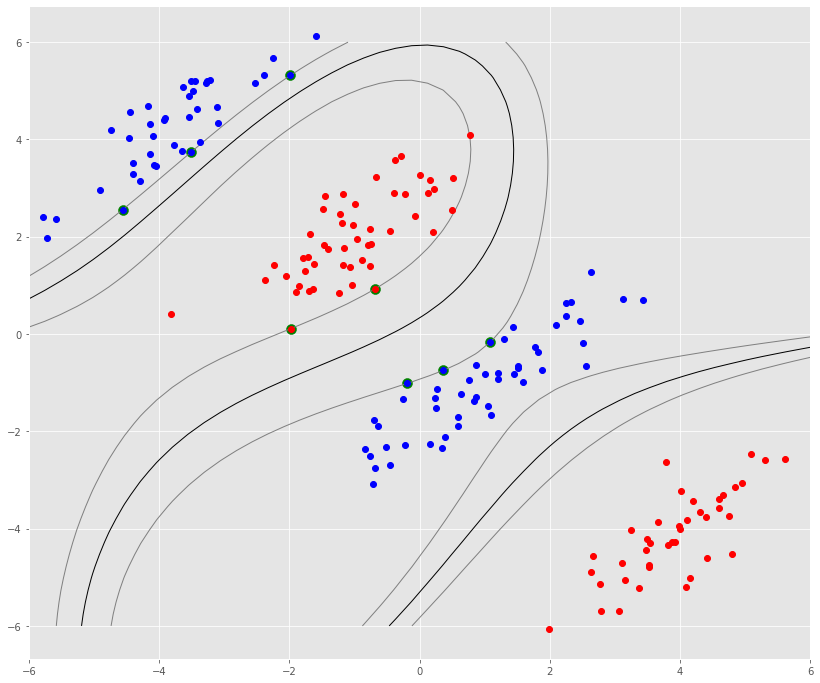

     pcost       dcost       gap    pres   dres
 0:  1.4654e+05 -9.0452e+07  2e+08  6e-01  4e-12
 1:  4.0518e+05 -1.6977e+07  3e+07  5e-02  2e-11
 2:  2.9211e+05 -3.3568e+06  5e+06  6e-03  4e-12
 3:  3.9402e+04 -4.8757e+05  5e+05  1e-04  3e-12
 4: -4.5736e+03 -5.1211e+04  5e+04  6e-06  2e-12
 5: -5.4933e+03 -2.3552e+04  2e+04  2e-06  2e-12
 6: -6.6710e+03 -2.4510e+04  2e+04  2e-06  3e-12
 7: -6.2358e+03 -2.3688e+04  2e+04  2e-06  3e-12
 8: -7.1349e+03 -2.2395e+04  2e+04  2e-06  3e-12
 9: -6.0744e+03 -2.1333e+04  2e+04  2e-06  3e-12
10: -7.2557e+03 -1.5720e+04  8e+03  7e-07  3e-12
11: -7.5613e+03 -1.1166e+04  4e+03  3e-07  3e-12
12: -8.2193e+03 -1.1655e+04  3e+03  2e-07  2e-12
13: -8.2950e+03 -1.1557e+04  3e+03  2e-07  3e-12
14: -9.0768e+03 -1.0500e+04  1e+03  6e-08  3e-12
15: -9.2805e+03 -1.0165e+04  9e+02  3e-08  3e-12
16: -9.2505e+03 -1.0115e+04  9e+02  2e-08  3e-12
17: -9.3360e+03 -1.0070e+04  7e+02  9e-09  4e-12
18: -9.3400e+03 -1.0054e+04  7e+02  8e-09  3e-12
19: -9.3999e+03 -9.93

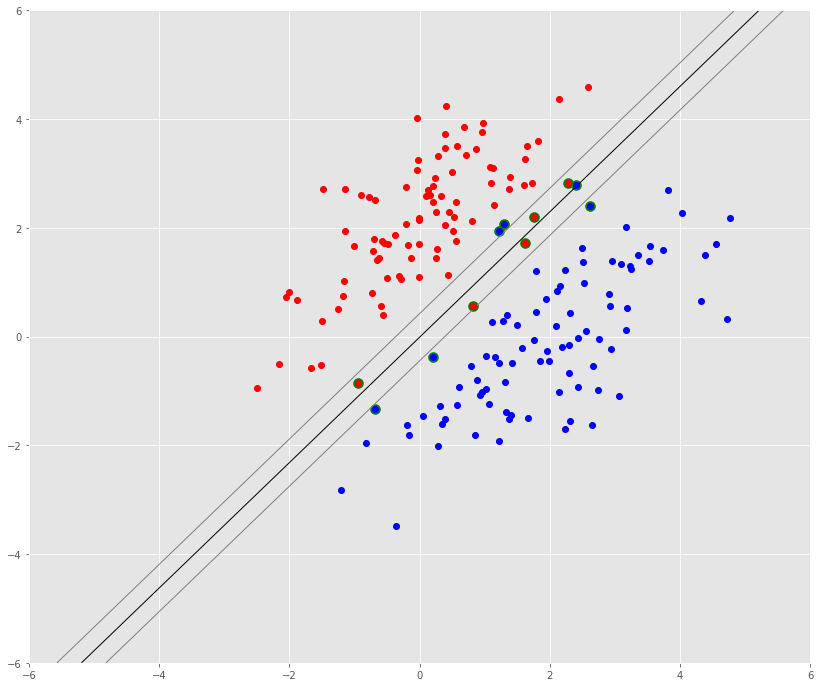

In [50]:
test_linear()
test_non_linear()
test_soft()